# Base - BERT

### Environment configuration


In [1]:
!pip install -qU transformers accelerate datasets==2.16.0 watermark textattack
!pip install pyarrow
!pip install "numpy<2"
!pip install -q pandas tqdm

%reload_ext watermark
%watermark -vmp transformers,datasets,torch,numpy,pandas,tqdm

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Python implementation: CPython
Python version       : 3.12.12
IPython version      : 7.34.0

transformers: 4.57.1
datasets    : 2.16.0
torch       : 2.8.0+cu126
numpy       : 1.26.4
pandas      : 2.2.2
tqdm        : 4.67.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.6.105+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

Using device: cuda


## Dataset

https://huggingface.co/datasets/takala/financial_phrasebank

In [2]:
from datasets import load_dataset, DatasetDict, ClassLabel, Dataset

dataset = load_dataset("takala/financial_phrasebank", "sentences_50agree")

full_dataset = dataset['train']

split_dataset = full_dataset.train_test_split(test_size=0.2, seed=42)
test_valid_split = split_dataset['test'].train_test_split(test_size=0.5, seed=42)

dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': test_valid_split['train'],
    'test': test_valid_split['test']
})

print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/datasets/load.py:1429: FutureWarning: The repository for takala/financial_phrasebank contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/takala/financial_phrasebank
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 3876
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 485
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 485
    })
})


In [3]:
import pandas as pd
import numpy as np
import datasets
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    """Display num_examples random examples from the dataset.
    """
    indices = np.random.randint(0, len(dataset), num_examples)
    df = pd.DataFrame(dataset[indices])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

def get_class_distribution(dataset):
    print("Classes distribution:")
    for k in dataset.keys():
        print(k)
        print(pd.Series(dataset[k]["label"]).value_counts())
        print("-"*70)

np.random.seed(33)


In [4]:
print(get_class_distribution(dataset))
print(show_random_elements(dataset["train"], num_examples=3))

Classes distribution:
train
1    2302
2    1086
0     488
Name: count, dtype: int64
----------------------------------------------------------------------
validation
1    295
2    134
0     56
Name: count, dtype: int64
----------------------------------------------------------------------
test
1    282
2    143
0     60
Name: count, dtype: int64
----------------------------------------------------------------------
None


,sentence,label
0,"Operating profit for the 12-month period decreased from EUR5 .4 m while net sales increased from EUR62 .0 m , as compared to the financial year 2004 .",negative
1,"Thus the group 's balance sheet will have about EUR25 .8 m of goodwill , the company added .",neutral
2,"Salcomp Oyj , the Finnish maker of mobile phone chargers , Monday posted a EUR1 .49 million loss in the second quarter compared with a 1.70 million profit in the same period the previous year .",negative


None


In [5]:
label_names = dataset["train"].features["label"].names
label2id = {name: dataset["train"].features["label"].str2int(name) for name in label_names}
id2label = {id: label for label, id in label2id.items()}

print("Label names: ", label_names)
print("Label ids: ", label2id["negative"], label2id['neutral'], label2id["positive"])

Label names:  ['negative', 'neutral', 'positive']
Label ids:  0 1 2


## Fine-tuning DistilBERT

[DistinBERT Base Model](https://huggingface.co/distilbert/distilbert-base-uncased)

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_checkpoint = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
bert_model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
).to(device)

print(bert_model)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


#### Tokenization

In [7]:
def tokenize_fn(examples):
    return tokenizer(
        examples["sentence"], truncation=True, max_length=tokenizer.model_max_length
    )

tokenized_dataset = dataset.map(tokenize_fn)
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

In [8]:
param_names = [name for name, _ in bert_model.named_parameters()]
print(len(param_names))
print(param_names[:5])
print(param_names[-5:])

104
['distilbert.embeddings.word_embeddings.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight']
['distilbert.transformer.layer.5.output_layer_norm.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']


In [9]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [10]:
from transformers import EvalPrediction
from torch import nn

loss_fn = nn.CrossEntropyLoss()

def compute_metrics(logits, labels):
    """Args:
        logits: array shape (batch_size, num_labels)
        labels: array shape (batch_size,)
    """
    if not isinstance(logits, torch.Tensor):
        logits = torch.tensor(logits)
    if not isinstance(labels, torch.Tensor):
        labels = torch.tensor(labels)
    predictions = torch.argmax(logits, dim=-1)
    accuracy = (predictions == labels).float().mean().item()
    cross_entropy = loss_fn(logits, labels).item()
    return {"accuracy": accuracy, "cross_entropy": cross_entropy}

def compute_metrics_for_hf(pred: EvalPrediction) -> dict:
    """EvalPrediction: tupla con dos elementos: predictions y label_ids
    NOTE Trainer will put in EvalPrediction everything the model returns.
    """
    logits = pred.predictions
    labels = pred.label_ids
    return compute_metrics(logits, labels)

In [11]:
batch_size = 16
learning_rate = 2e-5
n_epochs = 3
optimization_steps = int(np.ceil(len(tokenized_dataset["train"]) * n_epochs / batch_size))

In [12]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    "bert-ft-sentiment",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    max_steps=optimization_steps,
    weight_decay=0.01,
    eval_strategy="steps",
    logging_strategy="steps",
    eval_steps=50,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    seed=33,
    report_to="none",
)

trainer = Trainer(
    bert_model, args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_for_hf,
)


/tmp/ipython-input-2672427418.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [13]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Cross Entropy
50,0.901800,0.697885,0.696907,0.697885
100,0.627800,0.517250,0.779381,0.517250
150,0.474300,0.437084,0.820619,0.437084
200,0.464400,0.431429,0.820619,0.431429
250,0.389000,0.426871,0.814433,0.426871
300,0.322700,0.422372,0.818557,0.422372
350,0.283700,0.403694,0.835052,0.403694
400,0.274800,0.429514,0.837113,0.429514
450,0.304500,0.391933,0.845361,0.391933
500,0.221700,0.410172,0.832990,0.410172


TrainOutput(global_step=727, training_loss=0.35508154117421564, metrics={'train_runtime': 93.4616, 'train_samples_per_second': 124.458, 'train_steps_per_second': 7.779, 'total_flos': 177567435292608.0, 'train_loss': 0.35508154117421564, 'epoch': 2.991769547325103})

In [14]:
# Evaluar en test:
test_results = trainer.evaluate(tokenized_dataset["test"])

In [15]:
print(test_results)

{'eval_loss': 0.45733433961868286, 'eval_accuracy': 0.839175283908844, 'eval_cross_entropy': 0.45733436942100525, 'eval_runtime': 0.9241, 'eval_samples_per_second': 524.862, 'eval_steps_per_second': 33.548, 'epoch': 2.991769547325103}


# Learning Rate

En esta sección se analiza el impacto del *learning rate* sobre el desempeño del modelo.
El *learning rate* es un hiperparámetro clave en el proceso de optimización, ya que determina el tamaño de los pasos que da el optimizador al actualizar los pesos del modelo durante el entrenamiento. Valores demasiado altos pueden provocar que el modelo *diverja* (es decir, que no logre converger hacia un mínimo), mientras que valores demasiado bajos pueden hacer que el entrenamiento sea demasiado lento o quede atrapado en mínimos locales.
Para explorar este efecto, se entrenaron múltiples instancias del modelo DistilBERT con distintos learning rates, manteniendo constantes el resto de los hiperparámetros y el número de epochs. Cada modelo fue evaluado en el conjunto de validación y se registraron las métricas de desempeño (por ejemplo, *eval_loss* y *accuracy*).
De esta forma, es posible observar cómo pequeñas variaciones en el *learning rate* influyen directamente en la capacidad del modelo para generalizar sobre los datos.
Los resultados se presentan en forma de tabla y gráfico comparativo, lo que permite identificar el rango de *learning rates* más adecuado para este conjunto de datos y configuración de entrenamiento.


=== Entrenando con learning rate = 1e-05 ===


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3147811003.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lr = Trainer(


Step,Training Loss
50,0.988800
100,0.785100
150,0.619300
200,0.544900
250,0.497700
300,0.418000
350,0.369000
400,0.352900
450,0.382000
500,0.321000



=== Entrenando con learning rate = 2e-05 ===


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3147811003.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lr = Trainer(


Step,Training Loss
50,0.885600
100,0.647200
150,0.486400
200,0.462800
250,0.388800
300,0.327300
350,0.278900
400,0.277800
450,0.297500
500,0.236100



=== Entrenando con learning rate = 3e-05 ===


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3147811003.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lr = Trainer(


Step,Training Loss
50,0.816900
100,0.533200
150,0.451400
200,0.450600
250,0.358700
300,0.311200
350,0.251300
400,0.256900
450,0.286200
500,0.200800



=== Entrenando con learning rate = 5e-05 ===


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3147811003.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lr = Trainer(


Step,Training Loss
50,0.742400
100,0.476500
150,0.448500
200,0.435700
250,0.373900
300,0.279300
350,0.244300
400,0.255500
450,0.255100
500,0.177200


,learning_rate,eval_loss,eval_accuracy,eval_cross_entropy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.00001,0.405065,0.835052,0.405065,0.9141,530.595,33.914,3.0
1,0.00002,0.425106,0.843299,0.425106,0.9033,536.915,34.318,3.0
2,0.00003,0.455558,0.853608,0.455558,0.9287,522.214,33.379,3.0
3,0.00005,0.528948,0.863918,0.528948,0.9052,535.801,34.247,3.0


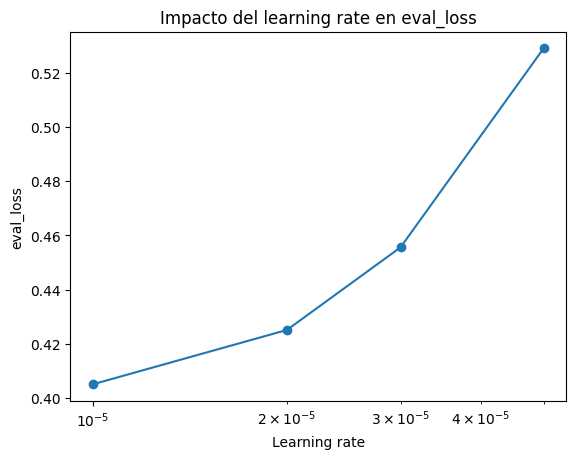

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
import matplotlib.pyplot as plt

learning_rates = [1e-5, 2e-5, 3e-5, 5e-5]

results = []

for lr in learning_rates:
    print(f"\n=== Entrenando con learning rate = {lr} ===")

    # Modelo nuevo para cada experimento (mismas etiquetas que antes)
    model_lr = AutoModelForSequenceClassification.from_pretrained(
        model_checkpoint,
        num_labels=3,
        id2label=id2label,
        label2id=label2id
    ).to(device)

    # Args simples y compatibles (sin evaluation_strategy)
    args_lr = TrainingArguments(
        output_dir=f"./bert-ft-sentiment-lr-{lr}",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=n_epochs,
        weight_decay=0.01,
        logging_steps=50,
        save_total_limit=1,
        seed=33,
        report_to="none"
    )

    trainer_lr = Trainer(
        model=model_lr,
        args=args_lr,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_for_hf,
    )

    trainer_lr.train()
    eval_metrics = trainer_lr.evaluate()

    row = {"learning_rate": lr}
    for k, v in eval_metrics.items():
        # nos aseguramos de que sea serializable
        try:
            row[k] = float(v)
        except (TypeError, ValueError):
            row[k] = v
    results.append(row)

# Tabla comparativa
df_results = pd.DataFrame(results)
display(df_results)

# Gráfico si está la métrica disponible
metric_candidates = ["eval_loss", "eval_accuracy", "accuracy"]
metric_to_plot = next((m for m in metric_candidates if m in df_results.columns), None)

if metric_to_plot:
    plt.plot(df_results["learning_rate"], df_results[metric_to_plot], marker="o")
    plt.xscale("log")
    plt.xlabel("Learning rate")
    plt.ylabel(metric_to_plot)
    plt.title(f"Impacto del learning rate en {metric_to_plot}")
    plt.show()
else:
    print("No se encontró ninguna métrica estándar para graficar. Columnas:", df_results.columns.tolist())
